# Tweet Classification

Dataset and Problem Url:<br>
https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-mothers-day/

Used Code from:<br>
https://github.com/gauravbansal98/Sentiment-classification-on-news-of-disaster-on-social-media-02-06-2018<br>
https://www.oreilly.com/content/perform-sentiment-analysis-with-lstms-using-tensorflow/<br>
https://www.curiousily.com/posts/sentiment-analysis-with-tensorflow-2-and-keras-using-python/<br>

# Got very low accuracy on test set, hence not used for submission

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import keras
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm   # can be used for showing progress bar for any iteration

import random 
import time
import re
import codecs

#Natural Language Toolkit
import nltk
# nltk.download()

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

PATH = os.getcwd()
print("Present working directory: ", PATH, "\n")

for dirname, _,filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


Present working directory:  /mnt/8CFE7DA1FE7D846C/Practice/Git/Active/Machine_Learning_Projects/Mothers’_Day_with_Machine_Learning 

/mnt/8CFE7DA1FE7D846C/Practice/Git/Active/Machine_Learning_Projects/Mothers’_Day_with_Machine_Learning/idsMatrix.npy
/mnt/8CFE7DA1FE7D846C/Practice/Git/Active/Machine_Learning_Projects/Mothers’_Day_with_Machine_Learning/Notebook(Complete-1).ipynb
/mnt/8CFE7DA1FE7D846C/Practice/Git/Active/Machine_Learning_Projects/Mothers’_Day_with_Machine_Learning/Notebook(Not_Complete-1).ipynb
/mnt/8CFE7DA1FE7D846C/Practice/Git/Active/Machine_Learning_Projects/Mothers’_Day_with_Machine_Learning/Notebook(Not_Complete-2).ipynb
/mnt/8CFE7DA1FE7D846C/Practice/Git/Active/Machine_Learning_Projects/Mothers’_Day_with_Machine_Learning/test_tweet.csv
/mnt/8CFE7DA1FE7D846C/Practice/Git/Active/Machine_Learning_Projects/Mothers’_Day_with_Machine_Learning/train_tweet.csv
/mnt/8CFE7DA1FE7D846C/Practice/Git/Active/Machine_Learning_Projects/Mothers’_Day_with_Machine_Learning/.ipynb_check

In [2]:
#Loading CSV Training Data

train_data = pd.read_csv('./dataset/train.csv')
train_data = train_data[['original_text', 'sentiment_class']]
print(train_data.head())

#Loading CSV Test Data

test_data = pd.read_csv("./dataset/test.csv")
test_data = test_data[['original_text']]
print(test_data.head())

                                       original_text  sentiment_class
0  Happy #MothersDay to all you amazing mothers o...                0
1  Happy Mothers Day Mum - I'm sorry I can't be t...                0
2  Happy mothers day To all This doing a mothers ...               -1
3  Happy mothers day to this beautiful woman...ro...                0
4  Remembering the 3 most amazing ladies who made...               -1
                                       original_text
0  3. Yeah, I once cooked potatoes when I was 3 y...
1  Happy Mother's Day to all the mums, step-mums,...
2  I love the people from the UK, however, when I...
3  Happy 81st Birthday Happy Mother’s Day to my m...
4  Happy Mothers day to all those wonderful mothe...


In [3]:
#Standardizing text in the tweet, removing all types of sybmbols from the tweets

def standardize_tweets(tweet, text_field):
    tweet[text_field] = tweet[text_field].str.replace(r"http\S+", "")
    tweet[text_field] = tweet[text_field].str.replace(r'http','')
    tweet[text_field] = tweet[text_field].str.replace(r'!','')
    tweet[text_field] = tweet[text_field].str.replace(r'@S\+','')
    tweet[text_field] = tweet[text_field].str.replace(r'[^A-Za-z0-9(),!?@\'\`\"\_\n]',' ')
    tweet[text_field] = tweet[text_field].str.replace(r'@','at')
    tweet[text_field] = tweet[text_field].str.lower()
    return tweet
   
    
train_data = standardize_tweets(train_data, "original_text")
# train_data.to_csv("train_tweet.csv")

test_data = standardize_tweets(test_data, "original_text")
# test_data.to_csv("test_tweet.csv")

train_data.head()

,original_text,sentiment_class
0,happy mothersday to all you amazing mothers o...,0
1,happy mothers day mum i'm sorry i can't be t...,0
2,happy mothers day to all this doing a mothers ...,-1
3,happy mothers day to this beautiful woman ro...,0
4,remembering the 3 most amazing ladies who made...,-1


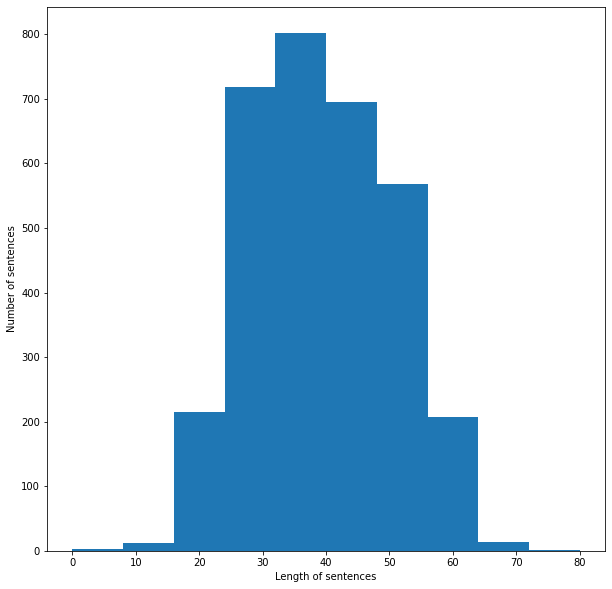

Average length of a sentence:  38.76259659969088


In [4]:
def plot_length_sentences():
    file = train_data
    tweets = file['original_text']
    sentences_length = []
    for line in tweets:
        words = word_tokenize(line)
        sentences_length.append(len(words))
        
    fig = plt.figure(figsize = (10, 10))
    plt.xlabel('Length of sentences')
    plt.ylabel('Number of sentences')
    plt.hist(sentences_length, range=(0, 80))
    plt.show()
    
    return sentences_length

sentences_length = plot_length_sentences()
print('Average length of a sentence: ',sum(sentences_length)/len(train_data['original_text']))

In [5]:
train_data.groupby('sentiment_class').count()

,original_text
sentiment_class,
-1,769
0,1701
1,765


# Based on O'Reilly Tutorial
https://www.oreilly.com/content/perform-sentiment-analysis-with-lstms-using-tensorflow/

In [6]:
wordVectors = np.load("../glove.6B.100d.npy")
print("Loaded the word list!")

with codecs.open("../glove.6B.100d.vocab", 'r', 'utf-8') as f_in:
    wordsList = [line.strip() for line in tqdm(f_in)]
    
print('Loaded the word Vectors!')

0it [00:00, ?it/s]

Loaded the word list!


399999it [00:01, 373099.95it/s]

Loaded the word Vectors!


In [7]:
print(len(wordsList))
print(wordVectors.shape)

399999
(399999, 100)


In [8]:
helloIndex = wordsList.index('hello')
wordVectors[helloIndex]

array([ 0.26688  ,  0.39632  ,  0.6169   , -0.77451  , -0.1039   ,
        0.26697  ,  0.2788   ,  0.30992  ,  0.0054685, -0.085256 ,
        0.73602  , -0.098432 ,  0.5479   , -0.030305 ,  0.33479  ,
        0.14094  , -0.0070003,  0.32569  ,  0.22902  ,  0.46557  ,
       -0.19531  ,  0.37491  , -0.7139   , -0.51775  ,  0.77039  ,
        1.0881   , -0.66011  , -0.16234  ,  0.9119   ,  0.21046  ,
        0.047494 ,  1.0019   ,  1.1133   ,  0.70094  , -0.08696  ,
        0.47571  ,  0.1636   , -0.44469  ,  0.4469   , -0.93817  ,
        0.013101 ,  0.085964 , -0.67456  ,  0.49662  , -0.037827 ,
       -0.11038  , -0.28612  ,  0.074606 , -0.31527  , -0.093774 ,
       -0.57069  ,  0.66865  ,  0.45307  , -0.34154  , -0.7166   ,
       -0.75273  ,  0.075212 ,  0.57903  , -0.1191   , -0.11379  ,
       -0.10026  ,  0.71341  , -1.1574   , -0.74026  ,  0.40452  ,
        0.18023  ,  0.21449  ,  0.37638  ,  0.11239  , -0.53639  ,
       -0.025092 ,  0.31886  , -0.25013  , -0.63283  , -0.0118

In [9]:
lengths = [len(line.split()) for line in train_data['original_text']]

maxSeqLength = max(lengths)
print(maxSeqLength)

66


In [10]:
numDimensions = 100

firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
# firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#firstSentence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence)

(66,)
[   40   803     0  1004    14  7445     4 13766     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [11]:
firstFile = np.zeros((maxSeqLength, 1), dtype='int32')

indexCounter = 0
tweet = train_data['original_text'][0]

split = tweet.split()
for word in split:
    try:
        firstFile[indexCounter] = wordsList.index(word)
    except ValueError:
        firstFile[indexCounter] = 400000
    indexCounter = indexCounter + 1

firstFile

array([[  1750],
       [400000],
       [     3],
       [    63],
       [    80],
       [  5771],
       [  5833],
       [    65],
       [    62],
       [    40],
       [   345],
       [400000],
       [   604],
       [    35],
       [   133],
       [   666],
       [     3],
       [   252],
       [   391],
       [  5833],
       [   372],
       [    33],
       [400000],
       [    12],
       [    63],
       [     2],
       [    94],
       [     3],
       [    87],
       [   101],
       [    52],
       [    85],
       [     3],
       [  1507],
       [400000],
       [    95],
       [  4589],
       [   234],
       [     2],
       [   161],
       [   907],
       [400000],
       [ 42772],
       [ 10359],
       [ 10107],
       [400000],
       [     0],
       [     0],
       [     0],
       [     0],
       [     0],
       [     0],
       [     0],
       [     0],
       [     0],
       [     0],
       [     0],
       [     0],
       [     0

In [12]:
numFiles = len(train_data['original_text'])
# print(numFiles)

ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
tweetCounter = 0

for tweet in tqdm(train_data['original_text']):
    indexCounter = 0
    words = tweet.split()
    
    for word in words:
        try:
            ids[tweetCounter][indexCounter] = wordsList.index(word)
        except ValueError:
            ids[tweetCounter][indexCounter] = 399999
        indexCounter = indexCounter + 1
        if indexCounter > maxSeqLength:
            print("Err. %f more that maxSeqLength , breaking loop!" %indexCounter)
            break
    tweetCounter = tweetCounter + 1
    
np.save('idsMatrix', ids)

100%|██████████| 3235/3235 [03:24<00:00, 15.79it/s]


In [13]:
tweets_traning = np.load('idsMatrix.npy')

# Based on curiousily
https://www.curiousily.com/posts/sentiment-analysis-with-tensorflow-2-and-keras-using-python/

In [14]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
    train_data.sentiment_class.to_numpy().reshape(-1, 1) )

In [15]:
from sklearn.model_selection import train_test_split

temp_train, temp_test, y_train, y_test = train_test_split(
    train_data.original_text, type_one_hot, test_size=0.1,
    random_state = 0)

In [16]:
numFiles = len(train_data['original_text'])

X_train = np.zeros((temp_train.shape[0], maxSeqLength), dtype='int32')
tweetCounter = 0

for tweet in tqdm(temp_train):
    indexCounter = 0
    words = tweet.split()
    
    for word in words:
        try:
            X_train[tweetCounter][indexCounter] = wordsList.index(word)
        except ValueError:
            X_train[tweetCounter][indexCounter] = 399999
        indexCounter = indexCounter + 1
        if indexCounter > maxSeqLength:
            print("Err. %f more that maxSeqLength , breaking loop!" %indexCounter)
            break
    tweetCounter = tweetCounter + 1
    
X_test = np.zeros((temp_test.shape[0], maxSeqLength), dtype='int32')
tweetCounter = 0

for tweet in tqdm(temp_test):
    indexCounter = 0
    words = tweet.split()
    
    for word in words:
        try:
            X_test[tweetCounter][indexCounter] = wordsList.index(word)
        except ValueError:
            X_test[tweetCounter][indexCounter] = 399999
        indexCounter = indexCounter + 1
        if indexCounter > maxSeqLength:
            print("Err. %f more that maxSeqLength , breaking loop!" %indexCounter)
            break
    tweetCounter = tweetCounter + 1

100%|██████████| 324/324 [00:23<00:00, 13.89it/s]


In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2911, 66) (2911, 3)
(324, 66) (324, 3)


In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, input_shape=(X_train.shape[1], ), activation='relu'),
    tf.keras.layers.Dropout(rate=0.01),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(rate=0.01),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               17152     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 50,435
Trainable params: 50,435
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train,epochs=20, batch_size=5, validation_split=0.1, verbose=1, shuffle=True)

Train on 2619 samples, validate on 292 samples
Epoch 1/20
2619/2619 [==============================] - 5s 2ms/sample - loss: 1.3026 - accuracy: 0.5296 - val_loss: 1.0386 - val_accuracy: 0.5034
Epoch 2/20
2619/2619 [==============================] - 6s 2ms/sample - loss: 1.6199 - accuracy: 0.5292 - val_loss: 1.0365 - val_accuracy: 0.5034
Epoch 3/20
2619/2619 [==============================] - 5s 2ms/sample - loss: 1.4552 - accuracy: 0.5292 - val_loss: 1.0388 - val_accuracy: 0.5034
Epoch 4/20
2619/2619 [==============================] - 6s 2ms/sample - loss: 1.0147 - accuracy: 0.5300 - val_loss: 1.0384 - val_accuracy: 0.5034
Epoch 5/20
2619/2619 [==============================] - 5s 2ms/sample - loss: 1.0547 - accuracy: 0.5300 - val_loss: 1.0384 - val_accuracy: 0.5034
Epoch 6/20
2619/2619 [==============================] - 5s 2ms/sample - loss: 1.5866 - accuracy: 0.5300 - val_loss: 1.0384 - val_accuracy: 0.5034
Epoch 7/20
2619/2619 [==============================] - 6s 2ms/sample - loss:

In [21]:
model.evaluate(X_test, y_test)

324/324 [==============================] - 0s 322us/sample - loss: 19.0853 - accuracy: 0.5185


[19.085279517703587, 0.5185185]

In [22]:
tweets = test_data['original_text']
model.predict(X_test[:1])

ValueError: Error when checking input: expected dense_input to have shape (66,) but got array with shape (1,)